# chapter 8. Text Analysis

## Document Similarity

### 문서 유사도 측정 방법 - 코사인 유사도 

In [1]:
import sklearn
print(sklearn.__version__)

1.3.0


In [2]:
import numpy as np

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
    similarity = dot_product / l2_norm     
    
    return similarity

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends' ,
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 18)


In [4]:
feature_vect_dense = feature_vect_simple.todense()
feature_vect_dense

matrix([[0.4155636 , 0.        , 0.4155636 , 0.        , 0.        ,
         0.        , 0.24543856, 0.        , 0.24543856, 0.        ,
         0.        , 0.        , 0.        , 0.4155636 , 0.24543856,
         0.49087711, 0.        , 0.24543856],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.23402865, 0.39624495, 0.23402865, 0.        ,
         0.3013545 , 0.        , 0.39624495, 0.        , 0.23402865,
         0.23402865, 0.39624495, 0.4680573 ],
        [0.        , 0.30985601, 0.        , 0.30985601, 0.30985601,
         0.30985601, 0.18300595, 0.        , 0.18300595, 0.30985601,
         0.23565348, 0.30985601, 0.        , 0.        , 0.18300595,
         0.3660119 , 0.        , 0.3660119 ]])

In [6]:
np.array(feature_vect_dense[0]).reshape(-1, )

array([0.4155636 , 0.        , 0.4155636 , 0.        , 0.        ,
       0.        , 0.24543856, 0.        , 0.24543856, 0.        ,
       0.        , 0.        , 0.        , 0.4155636 , 0.24543856,
       0.49087711, 0.        , 0.24543856])

In [7]:
# TFidfVectorizer로 transform()한 결과는 Sparse Matrix이므로 Dense Matrix로 변환 
feature_vect_dense = feature_vect_simple.todense()

#첫번째 문장과 두번째 문장의 feature vector 추출
vect1 = np.array(feature_vect_dense[0]).reshape(-1, )
vect2 = np.array(feature_vect_dense[1]).reshape(-1, )

#첫번째 문장과 두번째 문장의 feature vector로 두개 문장의 Cosine 유사도 추출
similarity_simple = cos_similarity(vect1, vect2 )
print('문장 1, 문장 2 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 2 Cosine 유사도: 0.402


In [8]:
vect1 = np.array(feature_vect_dense[0]).reshape(-1, )
vect3 = np.array(feature_vect_dense[2]).reshape(-1, )
similarity_simple = cos_similarity(vect1, vect3 )
print('문장 1, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

vect2 = np.array(feature_vect_dense[1]).reshape(-1, )
vect3 = np.array(feature_vect_dense[2]).reshape(-1, )
similarity_simple = cos_similarity(vect2, vect3 )
print('문장 2, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 3 Cosine 유사도: 0.404
문장 2, 문장 3 Cosine 유사도: 0.456


In [9]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]


In [10]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple[1:])
print(similarity_simple_pair)

[[0.40207758 0.40425045]]


In [11]:
similarity_simple_pair = cosine_similarity(feature_vect_simple, feature_vect_simple)
print(similarity_simple_pair)
print('shape:', similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape: (3, 3)


### Opinion Review 데이터 셋을 이용한 문서 유사도 측정

In [12]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

# 입력으로 들어온 token단어들에 대해서 lemmatization 어근 변환
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# TfidfVectorizer 객체 생성 시 tokenizer인자로 해당 함수를 설정하여 lemmatization 적용
# 입력으로 문장을 받아서 stop words 제거 -> 소문자 변환 -> 단어 토큰화 -> lemmatization 어근 변환 
def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [13]:
import pandas as pd
import glob ,os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

path = r'data/opinosis dataset/topics'
all_files = glob.glob(os.path.join(path, "*.data"))     
filename_list = []
opinion_text = []

for file_ in all_files:
    df = pd.read_table(file_,index_col = None, header = 0, encoding = 'latin1')
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]
    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})

tfidf_vect = TfidfVectorizer(tokenizer = LemNormalize, stop_words = 'english', \
                             ngram_range = (1,2), min_df = 0.05, max_df = 0.85)
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster = KMeans(n_clusters = 3, max_iter = 10000, random_state = 0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

In [14]:
document_df.head(51)

,filename,opinion_text,cluster_label
0,data/opinosis dataset/topics/battery-life_ipod...,...,1
1,data/opinosis dataset/topics/gas_mileage_toyot...,...,2
2,data/opinosis dataset/topics/room_holiday_inn_...,...,0
3,data/opinosis dataset/topics/location_holiday_...,...,0
4,data/opinosis dataset/topics/staff_bestwestern...,...,0
5,data/opinosis dataset/topics/voice_garmin_nuvi...,...,1
6,data/opinosis dataset/topics/speed_garmin_nuvi...,...,1
7,data/opinosis dataset/topics/size_asus_netbook...,...,1
8,data/opinosis dataset/topics/screen_garmin_nuv...,...,1
9,data/opinosis dataset/topics/battery-life_amaz...,...,1


In [15]:
hotel_indexes = document_df[document_df['cluster_label'] == 2].index
hotel_indexes

Index([1, 18, 22, 23, 29, 35, 42, 43, 45, 47], dtype='int64')

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=2인 데이터는 호텔로 클러스터링된 데이터임. DataFrame에서 해당 Index를 추출
hotel_indexes = document_df[document_df['cluster_label'] == 2].index
print('호텔로 클러스터링 된 문서들의 DataFrame Index :', hotel_indexes)

# 호텔로 클러스터링된 데이터 중 첫번째 문서를 추출하여 파일명 표시.  
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('비교 기준 문서명',comparison_docname,' 와 타 문서 유사도')

''' document_df에서 추출한 Index 객체를 feature_vect로 입력하여 호텔 클러스터링된 feature_vect 추출 
이를 이용하여 호텔로 클러스터링된 문서 중 첫번째 문서와 다른 문서간의 코사인 유사도 측정.'''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 클러스터링 된 문서들의 DataFrame Index : Index([1, 18, 22, 23, 29, 35, 42, 43, 45, 47], dtype='int64')
비교 기준 문서명 data/opinosis dataset/topics/gas_mileage_toyota_camry_2007  와 타문서 유사도
[[1.         0.15655631 0.0879083  0.08217817 0.06276647 0.96608144
  0.14398794 0.27273923 0.05452321 0.20206332]]


가장 유사도가 큰 파일명 및 유사도:
 filename      data/opinosis dataset/topics/mileage_honda_acc...
similarity                                             0.966081
Name: 35, dtype: object


Text(0.5, 1.0, 'data/opinosis dataset/topics/gas_mileage_toyota_camry_2007')

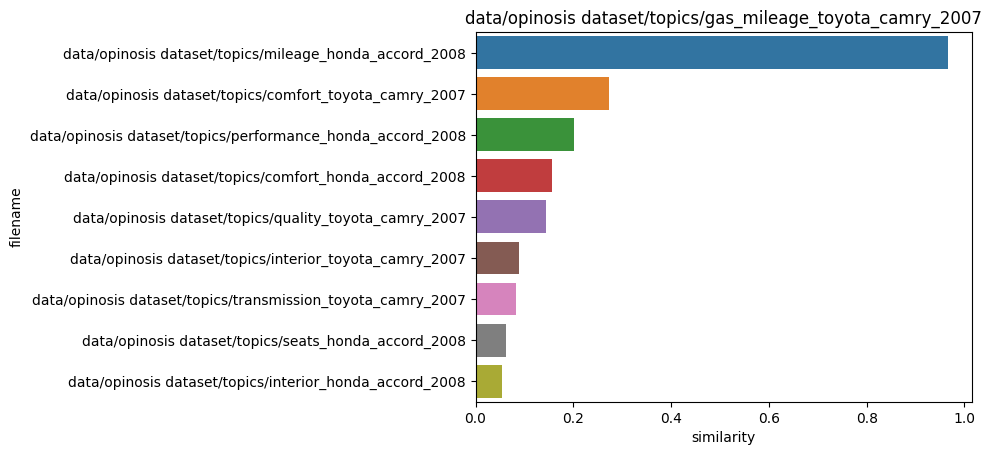

In [17]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# argsort()를 이용하여 앞 예제의 첫번째 문서와 타 문서간 유사도가 큰 순으로 정렬한 인덱스 추출하되 자기 자신은 제외한다.
sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:, 1:]

# 유사도가 큰 순으로 hotel_indexes를 추출하여 재정렬
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외한다.
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 인덱스와 유사도 값을 이용해 파일명과 유사도값을 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value
print('가장 유사도가 큰 파일명 및 유사도:\n', hotel_1_sim_df.iloc[0, :])

sns.barplot(x = 'similarity', y = 'filename', data = hotel_1_sim_df)
plt.title(comparison_docname)